In [6]:
import torch
from transformers import WhisperFeatureExtractor, WhisperModel
from datasets import load_dataset, load_from_disk

In [25]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
import cca_core

## Whisper

In [7]:
# 加载数据集
# ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
# ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation", cache_dir='/data/chenhonghua/datasets')
# ds.save_to_disk("/data/chenhonghua/datasets/librispeech_asr_dummy")

In [8]:
ds = load_from_disk("/data/chenhonghua/datasets/librispeech_asr_dummy")

In [108]:
model = WhisperModel.from_pretrained("openai/whisper-base")
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-base")

In [109]:
data = [ds[i]["audio"]["array"] for i in range(3)]
inputs = feature_extractor(data, return_tensors="pt")
input_features = inputs.input_features

It is strongly recommended to pass the `sampling_rate` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


In [111]:
decoder_input_ids = torch.tensor([[1, 1]]) * model.config.decoder_start_token_id
result = model(input_features, decoder_input_ids=decoder_input_ids)
last_hidden_state = result.last_hidden_state

In [124]:
model

WhisperModel(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 512)
    (layers): ModuleList(
      (0): WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=False)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
        (final_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      

In [26]:
ds[0]['file']
ipd.Audio(ds[0]['file'])

In [61]:
input_features[0].shape, ds[0]["audio"]["array"].shape, ds[0]["text"]

(torch.Size([80, 3000]),
 (93680,),
 'MISTER QUILTER IS THE APOSTLE OF THE MIDDLE CLASSES AND WE ARE GLAD TO WELCOME HIS GOSPEL')

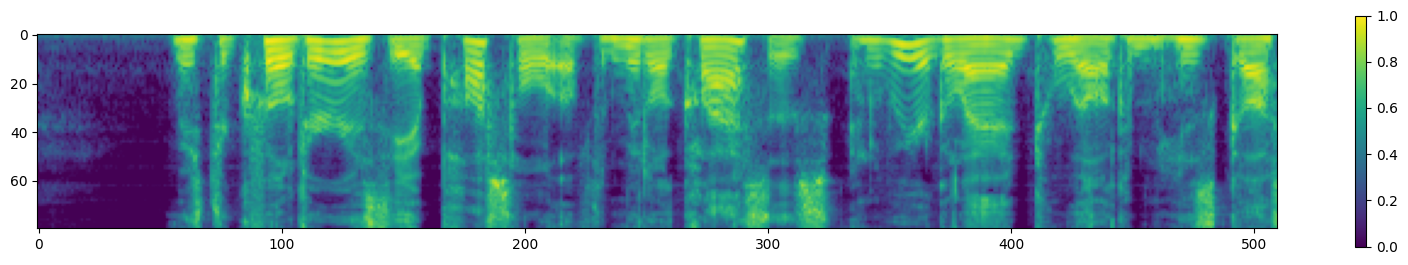

In [27]:
fig = plt.figure(figsize=(20, 3))
im = plt.imshow(input_features[0][:, :510])
fig.colorbar(mappable=None)
plt.show()

In [97]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
processor = WhisperProcessor.from_pretrained("openai/whisper-base")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-base")
generated_ids = model.generate(inputs=input_features)

/home/chenhonghua/anaconda3/envs/speech/lib/python3.7/site-packages/transformers-4.24.0-py3.7.egg/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 448 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


In [105]:
generated_ids.shape

torch.Size([3, 42])

In [104]:
transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)
transcription

[' Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.',
 " Nor is Mr. Quilter's manner less interesting than his matter.",
 ' He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similarly is drawn from eating and its results occur most readily to the mind.']

## Layer-wise analysis

### 模型加载